<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/mini_labs/week_8_naivebayes.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BYU CS 473 — Naive Bayes, Generative vs. Discriminative

In this assignment you will implement **Gaussian Naive Bayes** from scratch and compare it to a **discriminative** classifier (Logistic Regression).  
You will train both on a 2-class, 2-feature subset of the Iris dataset so decision boundaries can be plotted in 2D, then compare accuracy, training time, and qualitative differences.

---

**Learning goals**
- Implement the Naive Bayes generative model (Gaussian likelihoods, independent features).  
- Compute class priors and class-conditional parameters.  
- Visualize decision boundaries and posterior probabilities.  
- Compare to Logistic Regression (discriminative) and discuss tradeoffs.  

---

## Grading standards

| Component | Weight |
|---|---:|
| Data loading & preprocessing | 10% |
| Naive Bayes implementation (fit, predict, predict_proba) | 20% |
| Logistic Regression training & comparison | 20% |
| Decision boundary visualizations (clear & labeled) | 20% |
| Accuracy/time comparison + short writeup | 20% |
| Code tidy and notebook presentation | 10% |


---

## Description & Task Flow

You will perform the following parts.

**Part 1 — Implement Gaussian Naive Bayes (from scratch)**
- Implement a `NaiveBayes` class with these methods:
  - `fit(X, y)` — estimate class priors, per-class mean vectors, and per-class variances (use diagonal covariance because of the Naive Bayes independence assumption).
  - `predict_proba(X)` — return posterior probabilities for each class.
  - `predict(X)` — return class labels.
  - `score(X, y)` — return accuracy.
  - `generate_samples(n_samples)` — optional: sample new points from the learned generative model to demonstrate generative capability.
  - `visualize_decision_boundary(X, y)` — plot a 2D decision boundary and overlay data points and class means.

**Part 2 — Compare to Logistic Regression**
- Train `sklearn.linear_model.LogisticRegression` on the same data and compare:
  - Training time (use `time.time()` or `time.perf_counter()`).
  - Accuracy on the same train/test split.
  - Decision boundary side-by-side with Naive Bayes.
- Write a short reflection (3–5 sentences) that discusses when a generative model might be preferred over a discriminative model and vice versa.

**Data**
- Use `sklearn.datasets.load_iris()` and select two classes (for example, versicolor and virginica) and two features (e.g., petal length and petal width) to allow 2D plotting.

**Visualization requirements**
- Produce at least two labeled plots:
  1. Naive Bayes decision boundary with posterior coloring and class means.
  2. Logistic Regression decision boundary (same axes limits) for direct visual comparison.
- Optionally produce a third figure that overlays both decision boundaries.

---

## Deliverables (what to submit)
- A Colab notebook (or Jupyter) that contains:
  - Data loading and preprocessing code.
  - A `NaiveBayes` class with required methods (Part 1).
  - Training & evaluation code for Logistic Regression (Part 2).
  - Plots comparing the classifiers.
  - Short reflection paragraphs.

---

## Hints & Useful references
- Use `scipy.stats.norm.pdf` to compute 1D Gaussian likelihoods (or implement the Gaussian PDF directly).
- Use `sklearn.preprocessing.StandardScaler` to standardize features before training (optional but recommended).
- Use `np.log` versions (log-likelihood) to avoid numerical underflow when multiplying many likelihoods.
- For plotting decision boundaries create a meshgrid with `np.meshgrid` and evaluate `predict` (or `predict_proba`) on the grid.
- To sample from learned Gaussians, use `np.random.multivariate_normal` with diagonal covariances (i.e., variances on the diagonal).

---

</details>


In [1]:
# ===== Data loading and preprocessing =====
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load Iris and pick two classes + two features for 2D visualization
iris = load_iris()
X_all = iris['data']
y_all = iris['target']

# Choose classes 1 and 2 (versicolor, virginica) and features 2 and 3 (petal length, petal width)
mask = (y_all == 1) | (y_all == 2)
X = X_all[mask][:, 2:4]   # shape (n_samples, 2)
y = y_all[mask]
# Remap labels to {0,1}
y = (y == 2).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Optional: standardize
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

print("X_train:", X_train_s.shape, "y_train:", y_train.shape)



X_train: (70, 2) y_train: (70,)


In [2]:
# ===== A helper function for plotting decision boundires.
# You are expected to use it appropriately to produce at least two clear,
# well-labeled visualizations comparing Naive Bayes and Logistic Regression. =====

# You do NOT need to modify this function

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import time

def plot_mesh_predict(model, X, y, scaler=None, ax=None, title=None, cmap=None):
    """
    Plot decision region for a model with a .predict(X) method.
    If scaler is provided, the grid is created in scaled space.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    # define grid in original (unscaled) coordinates if scaler is provided:
    X_use = X if scaler is None else scaler.inverse_transform(X)
    x_min, x_max = X_use[:,0].min() - 1, X_use[:,0].max() + 1
    y_min, y_max = X_use[:,1].min() - 1, X_use[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    # if scaler given, transform grid to scaled space for model input
    grid_in = grid if scaler is None else scaler.transform(grid)
    Z = model.predict(grid_in).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25)
    ax.scatter(X_use[:,0], X_use[:,1], c=y, edgecolor='k')
    if title:
        ax.set_title(title)
    return ax

Logistic Regression training time: 0.0276 seconds
Logistic Regression test accuracy: 90.00%


<Axes: title={'center': 'Logistic Regression Decision Boundary'}>

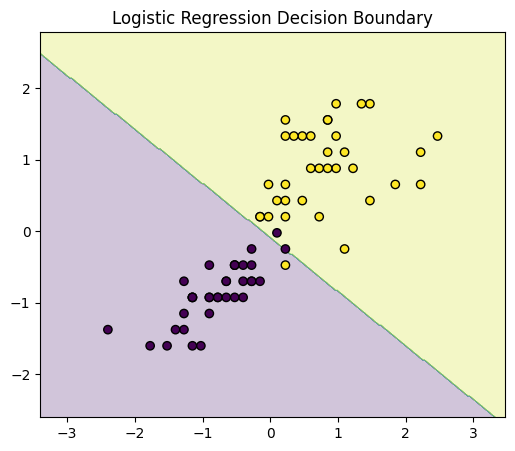

In [3]:
# ===== Implement the generative Naive Bayes =====

from sklearn.linear_model import LogisticRegression
import time

lr = LogisticRegression()

start = time.perf_counter()
lr.fit(X_train_s, y_train)
end = time.perf_counter()

print(f"Logistic Regression training time: {end - start:.4f} seconds")
print(f"Logistic Regression test accuracy: {(lr.score(X_test_s, y_test) * 100):.2f}%")

plot_mesh_predict(lr, X_train_s, y_train, title="Logistic Regression Decision Boundary")

In [4]:
from scipy.stats import norm

# ===== Implement the generative Naive Bayes =====
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.priors = None       # shape (n_classes,)
        self.means = None        # shape (n_classes, n_features)
        self.vars = None         # shape (n_classes, n_features)  (diagonal covariance)

    def fit(self, X, y):
        """
        Estimate class priors, means, and variances per class.
        X: array-like, shape (n_samples, n_features)
        y: array-like, shape (n_samples,)
        """

        self.classes = np.unique(y)       # create array of each unique class label
        n_classes = len(self.classes)
        n_features = X.shape[1]

        # Prepare storage for priors, means, and variances
        self.priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.vars = np.zeros((n_classes, n_features))

        # Iterate through the classes
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]                               # Create an array of every X[y] where y == c
            self.priors[idx] = X_c.shape[0] / X.shape[0]  # fraction of total samples that belong to class c.
            self.means[idx] = X_c.mean(axis=0)            # mean value of X_c
            self.vars[idx] = X_c.var(axis=0)              # 1/n ∑​(xi​ − mean)^2 (measure of how spread out the data is around the mean)
            self.vars[idx] += 1e-6                        # Add a tiny number to avoid later division by zero

    def predict_proba(self, X):
        """
        Return posterior probabilities for each class.
        Output shape: (n_samples, n_classes)
        """

        n_samples = X.shape[0]
        n_classes = len(self.classes)
        posterior = np.zeros((n_samples, n_classes))

        for idx, c in enumerate(self.classes):
            mu = self.means[idx]
            sigma = np.sqrt(self.vars[idx])
            likelihood = norm.pdf(X, loc=mu, scale=sigma)   # the PDFs of each feature of each sample under class c
            joint_likelihood = likelihood.prod(axis=1)      # the PDFs condensed into one joint likelihood per sample
            posterior[:, idx] = self.priors[idx] * joint_likelihood   # Multiply by the prior probability of class c

        posterior /= posterior.sum(axis=1, keepdims=True)         # Normalize
        return posterior

    def predict(self, X):
        """
        Return predicted class labels for each sample.
        """

        posterior = self.predict_proba(X)
        predictions = self.classes[np.argmax(posterior, axis=1)]
        return predictions

    def score(self, X, y):
        """
        Compute the accuracy of predictions on (X, y).
        """

        predictions = self.predict(X)
        return np.mean(predictions == y)

    def generate_samples(self, n_samples_per_class=50, random_state=None):
        """
        Optionally generate new samples from the learned generative model.
        Returns: (X_samples, y_samples)
        """

        if random_state is not None:
            np.random.seed(random_state)

        n_classes = len(self.classes)
        n_features = self.means.shape[1]

        X_samples = []
        y_samples = []

        for idx, c in enumerate(self.classes):
            mu = self.means[idx]
            cov = np.diag(self.vars[idx])
            samples = np.random.multivariate_normal(mu, cov, size=n_samples_per_class)
            X_samples.append(samples)
            y_samples.append(np.full(n_samples_per_class, c))

        X_samples = np.vstack(X_samples)
        y_samples = np.hstack(y_samples)

        return X_samples, y_samples

    def visualize_decision_boundary(self, X, y, ax=None):
        """
        Plot 2D decision boundary with training data and class means.
        Assumes 2 features.
        """

        if ax is None:
            fig, ax = plt.subplots(figsize=(6,6))

        x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
        y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

        grid = np.c_[xx.ravel(), yy.ravel()]  # shape (n_points, 2)
        Z = self.predict(grid)
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(len(self.classes)+1)-0.5, cmap=plt.cm.coolwarm)

        for idx, c in enumerate(self.classes):
            ax.scatter(X[y==c,0], X[y==c,1], label=f'Class {c}', edgecolor='k')

        ax.scatter(self.means[:,0], self.means[:,1], marker='X', s=100, c='black', label='Class means')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.legend()
        plt.show()


Naive Bayes training time: 0.0013 seconds
Test accuracy: 90.00%


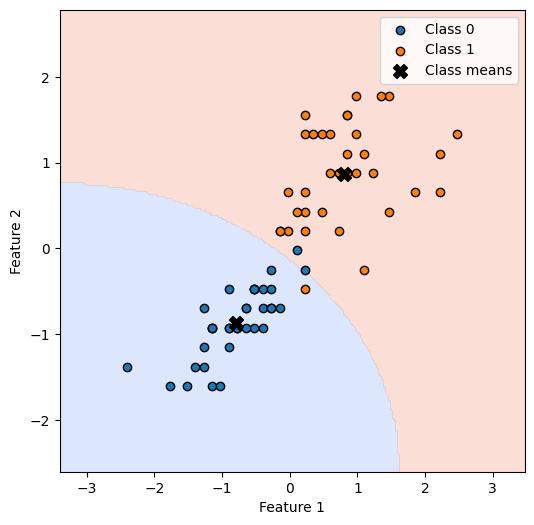

In [5]:
nb = NaiveBayes()

start = time.perf_counter()
nb.fit(X_train_s, y_train)
end = time.perf_counter()

test_acc = nb.score(X_test_s, y_test) * 100

print(f"Naive Bayes training time: {end - start:.4f} seconds")
print(f"Test accuracy: {test_acc:.2f}%")

nb.visualize_decision_boundary(X_train_s, y_train)

Compare your Naive Bayes implementation to Logistic Regression in terms of:

- Accuracy: At least 2 sentences discussing which model performed better and - possible reasons why.

- Training time: At least 2 sentences comparing how fast each model trained and implications.

- Decision boundary visualization: At least 2 sentences interpreting the shapes and differences of the boundaries from your plots.



Accuracy: Both Naive Bayes and Logistic Regression achieved the same 90% test accuracy on this dataset. Logistic Regression is a discriminative model that directly estimates class boundaries, while Naive Bayes is a generative model that assumes feature independence and models each class as a Gaussian; in this case, the independence assumption held well enough that both models performed equally.

Training time: Naive Bayes trained extremely quickly (0.0013 seconds) because it computes its statistics (means, variances, priors) in a single pass, whereas Logistic Regression took longer (0.0276 seconds) due to iterative optimization. This shows that for small datasets with simple features, Naive Bayes can be dramatically faster while still being accurate.

Decision boundary visualization: Logistic Regression produces a straight-line boundary because it models the decision as a linear combination of features. Naive Bayes produces a curved boundary around the class means due to the Gaussian likelihoods; this curve can better capture nonlinear separations in some datasets, though for this dataset the straight line from LR is already sufficient.